# 1. Import Packages and Define Functions

In [254]:
# Import some libraries that will be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import sys
sys.path.insert(1, '/Users/brianmccabe/DataScience/Flatiron/mod5/Emoji_Analysis/Scripts/')
import config
import warnings
warnings.filterwarnings('ignore')



pd.set_option('display.max_columns', 300)

%matplotlib inline

In [255]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
import string
import scipy
import emoji
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
from textblob import TextBlob

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [256]:
from tqdm import tqdm
tqdm.pandas()

In [257]:
# we can define a function that removes stopwords 
def process_tweet(tweet):
    tweet = str(tweet).lower()
    tokens = nltk.word_tokenize(tweet)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords]
    return stopwords_removed

In [258]:
#set stopwords and punctuations
stopwords = stopwords.words('english')
stopwords += list(string.punctuation)
stopwords += ["n't", "' '", "'re'","”","``","“","''","’","'s","'re","http","https"]
alph = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
stopwords += alph

In [259]:
stopwords = list(set(stopwords))

In [260]:
def remove_http(tweet):
    pattern = '((http|https)\w+\s\w+\s\w+\s\w+)'
    try:
        return tweet.replace(re.findall(pattern, tweet)[0][0], "")
    except:
        return tweet

In [261]:
def capital_percentage(tweet):
    tokens = nltk.word_tokenize(tweet)
    cap_count = 0
    for item in tokens:
        if item.isupper():
            cap_count += 1
    return cap_count/len(tokens)

In [262]:
def remove_username(tweet):
    try:
        p = '[\w\s]+(@\w+)'
        return tweet.replace(re.findall(p, tweet)[0], "")
    except:
        return tweet

In [263]:
def check_profanity(tweet):
    profane = pd.read_csv("profane_words.csv", header=None)

    profane = list(profane.loc[:,0])
    count = 0
    tweet = tweet.lower()
    tokens = nltk.word_tokenize(tweet)
    for word in tokens:
        if word in profane:
            count += 1
    return count/len(tweet)

In [264]:
def fix_spelling(tweet):
    b = TextBlob(tweet)
    return b.correct()

In [265]:
from nltk.stem import WordNetLemmatizer, PorterStemmer
  
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [266]:
def clean_txt(tweet):
    tweet = remove_http(tweet)
    tweet = remove_username(tweet)
    tokens = process_tweet(tweet)
    return ' '.join([lemmatizer.lemmatize(w) for w in tokens])
    

In [267]:
analyzer = SentimentIntensityAnalyzer()
def return_sentiment(tweet):
    return analyzer.polarity_scores(tweet)['compound']

# 2. Load in Data and Preprocess

In [268]:
df = pd.read_csv("tweets_7_classes.csv").drop(['Unnamed: 0', 'emoji_frequency'], axis=1)
df.head()

,tweet,sentiment_score,top_emoji
0,Hello this has been KARINA and WINTER We re cu...,0.9840,😊
1,ilysm you deserve the world please you re awes...,0.7284,😍
2,Hey 965TDY I d like to hear Naughty List by li...,0.9168,😊
3,If I were to lift her up I d die SingleAndMing...,0.9723,😂
4,Mr Blair don t be a lier a Blier R G Mugabe RI...,0.4404,😂


In [269]:
print(df.tweet.iloc[0])
print(clean_txt(df.tweet.iloc[0]))
print(type(clean_txt(df.tweet.iloc[0])))

Hello this has been KARINA and WINTER We re currently looking for our dearest member t https t co w9NXwy7G8b
hello karina winter currently looking dearest member
<class 'str'>


In [270]:
# # Remove "http link stuff from all the tweets"
# print(df.tweet.iloc[0])
# print(remove_http(df.tweet.iloc[0]))

# df.tweet = df.tweet.apply(remove_http)

In [271]:
from sklearn.preprocessing import MinMaxScaler
normalizer = MinMaxScaler()
df.sentiment_score = normalizer.fit_transform(np.array(df.sentiment_score).reshape(-1,1))
df.sentiment_score.describe()

count    40462.000000
mean         0.608406
std          0.306372
min          0.000000
25%          0.329932
50%          0.720230
75%          0.885921
max          1.000000
Name: sentiment_score, dtype: float64

In [272]:
df['capitalization'] = df.tweet.progress_apply(capital_percentage)
df.head()

100%|██████████| 40462/40462 [00:04<00:00, 9991.94it/s] 


,tweet,sentiment_score,top_emoji,capitalization
0,Hello this has been KARINA and WINTER We re cu...,0.992098,😊,0.100000
1,ilysm you deserve the world please you re awes...,0.864266,😍,0.000000
2,Hey 965TDY I d like to hear Naughty List by li...,0.958490,😊,0.133333
3,If I were to lift her up I d die SingleAndMing...,0.986247,😂,0.133333
4,Mr Blair don t be a lier a Blier R G Mugabe RI...,0.720230,😂,0.176471


In [273]:
df['profanity'] = df.tweet.progress_apply(check_profanity)
df.head()

100%|██████████| 40462/40462 [01:18<00:00, 513.52it/s]


,tweet,sentiment_score,top_emoji,capitalization,profanity
0,Hello this has been KARINA and WINTER We re cu...,0.992098,😊,0.100000,0.000000
1,ilysm you deserve the world please you re awes...,0.864266,😍,0.000000,0.000000
2,Hey 965TDY I d like to hear Naughty List by li...,0.958490,😊,0.133333,0.000000
3,If I were to lift her up I d die SingleAndMing...,0.986247,😂,0.133333,0.014286
4,Mr Blair don t be a lier a Blier R G Mugabe RI...,0.720230,😂,0.176471,0.000000


# 3. Dummy Classifier for Baseline Model

In [274]:
# conditions = [
#     df.top_emoji == '😂',
#     df.top_emoji == '😭',
#     df.top_emoji == '😍',
#     df.top_emoji == '🤔',
#     df.top_emoji == '😊',
#     df.top_emoji == '😱',
#     df.top_emoji == '😡'
# ]
# choices = [
#     '0','1',2,3,4,5,6
# ]
# df['top_emoji'] = np.select(conditions, choices, None)


In [275]:
X = df.drop('top_emoji', axis=1)

In [276]:
y =df['top_emoji']

In [277]:
from sklearn.dummy import DummyClassifier

In [278]:
dummy_cf = DummyClassifier()
dummy_cf.fit(X['tweet'],y)
y_preds = dummy_cf.predict(X['tweet'])

print(dummy_cf.score(X['tweet'],y))

0.21615342790766645


In [279]:
accuracy = accuracy_score(y, y_preds)


In [280]:
results = []

In [281]:
results.append(('Dummy', accuracy))

In [282]:
results

[('Dummy', 0.21659828975334883)]

### Upsample

In [283]:
df.top_emoji.value_counts()

😂    13949
😭     8719
😍     7192
🤔     3740
😊     3230
😱     2477
😡     1155
Name: top_emoji, dtype: int64

In [291]:
len(anger).*1.5

SyntaxError: invalid syntax (<ipython-input-291-9e4e0024c594>, line 1)

In [292]:
from sklearn.utils import resample
laugh = df[df.top_emoji == '😂']
cry = df[df.top_emoji == '😭']
love = df[df.top_emoji == '😍']
wonder = df[df.top_emoji == '🤔']
happy = df[df.top_emoji == '😊']
fear = df[df.top_emoji == '😱']
anger = df[df.top_emoji == '😡']

laugh_downsampled = resample(laugh,
                                replace = False, # sample without replacement
                                n_samples = int(len(anger)*1.5), # match minority n
                                random_state = 40) # reproducible results

cry_downsampled = resample(cry,
                          replace=False, # sample with replacement
                          n_samples=int(len(anger)*1.5), # match number in majority class
                          random_state=40) 
love_downsampled = resample(love,
                          replace=False, # sample with replacement
                          n_samples=int(len(anger)*1.5), # match number in majority class
                          random_state=40) 
wonder_downsampled = resample(wonder,
                          replace=False, # sample with replacement
                          n_samples=int(len(anger)*1.5), # match number in majority class
                          random_state=40) 
happy_downsampled = resample(happy,
                          replace=False, # sample with replacement
                          n_samples=int(len(anger)*1.5), # match number in majority class
                          random_state=40) 
fear_downsampled = resample(fear,
                          replace=False, # sample with replacement
                          n_samples=int(len(anger)*1.5), # match number in majority class
                          random_state=40) 
anger_upsampled = resample(anger,
                          replace=True, # sample with replacement
                          n_samples=int(len(anger)*1.5), # match number in majority class
                          random_state=40) 

df = pd.concat([laugh_downsampled, cry_downsampled, love_downsampled, wonder_downsampled, happy_downsampled, 
                fear_downsampled, anger_upsampled])
df.top_emoji.value_counts()

😡    1732
😊    1732
😱    1732
🤔    1732
😭    1732
😂    1732
😍    1732
Name: top_emoji, dtype: int64

# 4. Supervised Learning

In [293]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.feature_extraction import DictVectorizer
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]


class TextStats(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, data):
        return [{'cap':  row['capitalization'], 'prof': row['profanity'], 'sent': row['sentiment_score']} for _, row in data.iterrows()]
    

In [294]:
pipeline = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for pulling features from the text
            ('text', Pipeline([
                ('selector', ItemSelector(key='tweet')),
                ('tfidf', TfidfVectorizer( min_df =3, max_df=0.2, max_features=None, 
                    strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                    ngram_range=(1, 10), use_idf=1,smooth_idf=1,sublinear_tf=1,
                    stop_words = None, preprocessor=clean_txt)),
            ])),

            # Pipeline for pulling metadata features
            ('stats', Pipeline([
                ('selector', ItemSelector(key=['capitalization', 'profanity', 'sentiment_score'])),
                ('stats', TextStats()),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ])),

        ],

        # weight components in FeatureUnion
        transformer_weights={
            'text': 0.9,
            'stats': 1.5,
        },
    ))
], verbose=True)

In [295]:
seed = 40
X = df[['tweet', 'capitalization', 'profanity', 'sentiment_score']]

X_train, X_test, y_train, y_test = train_test_split(X, df.top_emoji, test_size=0.2, random_state=seed, 
                                                    stratify=df.top_emoji)

In [296]:
pipeline.fit(X_train)

[Pipeline] ............. (step 1 of 1) Processing union, total=   3.8s


Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('text',
                                                 Pipeline(steps=[('selector',
                                                                  ItemSelector(key='tweet')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(max_df=0.2,
                                                                                  min_df=3,
                                                                                  ngram_range=(1,
                                                                                               10),
                                                                                  preprocessor=<function clean_txt at 0x1b2d3bdc0>,
                                                                                  smooth_idf=1,
                                                          

In [297]:
%%time
train_vec = pipeline.transform(X_train)
test_vec = pipeline.transform(X_test)
print("Checking that the shapes match: %s - %s" % (train_vec.shape, test_vec.shape))

Checking that the shapes match: (9699, 10100) - (2425, 10100)
CPU times: user 4.28 s, sys: 28.2 ms, total: 4.31 s
Wall time: 4.33 s


In [298]:
from sklearn.svm import LinearSVC

In [299]:
#Linear Support Vector Machines
sv_clf = LinearSVC(C=1, class_weight='balanced', multi_class='ovr', random_state=40,verbose=3) 
sv_clf.fit(train_vec, y_train)
test_preds = sv_clf.predict(test_vec)

[LibLinear]

In [300]:
accuracy = accuracy_score(y_test, test_preds)
print('Linear SVC')
print("Testing Accuracy: {:.4}".format(accuracy))

results.append(('SVM', accuracy))

Linear SVC
Testing Accuracy: 0.5023


In [301]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           😂       0.43      0.49      0.46       347
           😊       0.39      0.41      0.40       346
           😍       0.40      0.37      0.38       346
           😡       0.71      0.71      0.71       347
           😭       0.51      0.58      0.54       346
           😱       0.68      0.66      0.67       346
           🤔       0.38      0.29      0.33       347

    accuracy                           0.50      2425
   macro avg       0.50      0.50      0.50      2425
weighted avg       0.50      0.50      0.50      2425



In [302]:
rfc_clf = RandomForestClassifier(n_estimators=200,random_state=40,n_jobs=-1,verbose=1)
rfc_clf.fit(train_vec, y_train)
test_preds = rfc_clf.predict(test_vec)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished


In [303]:
accuracy = accuracy_score(y_test, test_preds)
print('Random Forest')
print("Testing Accuracy: {:.4}".format(accuracy))

results.append(('RFC', accuracy))

Random Forest
Testing Accuracy: 0.5897


In [304]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           😂       0.53      0.56      0.55       347
           😊       0.51      0.54      0.53       346
           😍       0.46      0.38      0.41       346
           😡       0.84      0.76      0.79       347
           😭       0.58      0.68      0.63       346
           😱       0.71      0.74      0.73       346
           🤔       0.50      0.47      0.49       347

    accuracy                           0.59      2425
   macro avg       0.59      0.59      0.59      2425
weighted avg       0.59      0.59      0.59      2425



In [305]:
print(confusion_matrix(y_test, test_preds))

[[195  70  27   5  10  18  22]
 [ 74 186  59   2   6   6  13]
 [ 55  71 130   8  18  15  49]
 [  5   4   9 262  23   6  38]
 [  7   7  20  16 237  30  29]
 [  1   3   9   5  59 256  13]
 [ 29  21  31  15  59  28 164]]


In [306]:
#Multinomial Naive Bayes
mnb_clf = MultinomialNB() 
mnb_clf.fit(train_vec, y_train)
test_preds = mnb_clf.predict(test_vec)

In [307]:
accuracy = accuracy_score(y_test, test_preds)
print('MN Bayes')
print("Testing Accuracy: {:.4}".format(accuracy))

results.append(('MNBayes', accuracy))

MN Bayes
Testing Accuracy: 0.3946


In [308]:
#Bernoulli Naive Bayes
bb_clf = BernoulliNB() 
bb_clf.fit(train_vec, y_train)
test_preds = bb_clf.predict(test_vec)

In [309]:
accuracy = accuracy_score(y_test, test_preds)
print('Bernoulli Bayes')
print("Testing Accuracy: {:.4}".format(accuracy))

results.append(('BerBayes', accuracy))

Bernoulli Bayes
Testing Accuracy: 0.3233


In [310]:
results

[('Dummy', 0.21659828975334883),
 ('SVM', 0.5022680412371134),
 ('RFC', 0.5896907216494846),
 ('MNBayes', 0.39463917525773196),
 ('BerBayes', 0.32329896907216493)]

In [311]:
from sklearn.linear_model import PassiveAggressiveClassifier

In [314]:
#PassiveAggresive Classifier
pac_clf = PassiveAggressiveClassifier() 
pac_clf.fit(train_vec, y_train)
test_preds = pac_clf.predict(test_vec)

In [315]:
accuracy = accuracy_score(y_test, test_preds)
print('MN Bayes')
print("Testing Accuracy: {:.4}".format(accuracy))

results.append(('PassiveAgg', accuracy))

MN Bayes
Testing Accuracy: 0.4619


In [316]:
results

[('Dummy', 0.21659828975334883),
 ('SVM', 0.5022680412371134),
 ('RFC', 0.5896907216494846),
 ('MNBayes', 0.39463917525773196),
 ('BerBayes', 0.32329896907216493),
 ('PassiveAgg', 0.4618556701030928)]

In [317]:
x = [x[0] for x in results]
y = [x[1] for x in results]

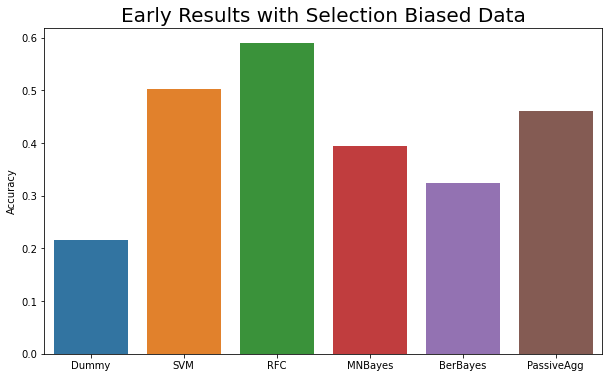

In [318]:
plt.figure(figsize=(10,6))
sns.barplot(x,y)
plt.ylabel('Accuracy')
plt.title("Early Results with Selection Biased Data", fontsize=20)
plt.savefig("/Users/brianmccabe/Desktop/Early_Results_Selection_Biased")

In [112]:
test_tweets = ['I love going to the beach',
              'I hate you',
              'Trump makes me so mad when he talks like that',
              'I am scared of the results',
              "I don't understand how this works",
              "You are amazing thank you for reaching out",
              "Why do people do that, it is just aweful",
              "That is so sad"]
model_testing = pd.DataFrame({'tweet': [], 'capitalization': [], 'profanity':[], 'sentiment_score':[]})
to_add = []
for tweet in test_tweets:
    row = {'tweet': tweet,
             'capitalization': capital_percentage(tweet),
             'profanity': check_profanity(tweet),
          'sentiment_score': return_sentiment(tweet)}
    to_add.append(row)

model_testing = model_testing.append(to_add) 


In [113]:
normalizer = MinMaxScaler()
model_testing.sentiment_score = normalizer.fit_transform(np.array(model_testing.sentiment_score).reshape(-1,1))
model_testing.sentiment_score.describe()

count    8.000000
mean     0.383160
std      0.383635
min      0.000000
25%      0.098050
50%      0.297471
75%      0.547364
max      1.000000
Name: sentiment_score, dtype: float64

,tweet,capitalization,profanity,sentiment_score
0,I love going to the beach,0.166667,0.000000,0.886695
1,I hate you,0.333333,0.000000,0.027989
2,Trump makes me so mad when he talks like that,0.000000,0.022222,0.160688
3,I am scared of the results,0.166667,0.000000,0.121404
4,I don't understand how this works,0.142857,0.000000,0.434254
5,You are amazing thank you for reaching out,0.000000,0.000000,1.000000
6,"Why do people do that, it is just aweful",0.000000,0.000000,0.434254
7,That is so sad,0.000000,0.000000,0.000000


In [125]:
%%time
model_testing_vec = pipeline.transform(model_testing)


CPU times: user 12.5 ms, sys: 4.88 ms, total: 17.4 ms
Wall time: 15.1 ms


In [126]:
model_testing_vec

<8x356246 sparse matrix of type '<class 'numpy.float64'>'
	with 46 stored elements in Compressed Sparse Row format>

In [127]:
model_testing_preds = sv_clf.predict(model_testing_vec)

In [128]:
model_testing_preds

array([2, 4, 4, 4, 0, 2, 6, 4])